#Predicting Ground State Energies of Electron in Simple Harmonic Potentials

Important-This is Notebook 1 of 2

**NAME-VATSALYA SHARAN**

**DEPT-PHY**

**ROLL_NO-18307**




**Importing all the required Libraries**

In [5]:
import numpy as np
import math
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import BatchNormalization


**Defining the function 'Solver_SHO' to solve and generate Simple Harmonic Potential Energies**

This gives output in the form of a list of images and energy labels

In [6]:
def Solver_SHO(limit, L, number):
    x = np.linspace(-limit, limit, L)
    y = np.linspace(-limit, limit, L)
    #grid spacing
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    mesh = np.meshgrid(x, y)
    block = sp.diags([-1,4,-1], [-1,0,1],(L,L)) #main tri-diagonal
    dia = sp.block_diag((block,)*L) #repeat it num times to create the main block
    sup = sp.diags([-1],[L],(L**2,L**2)) # super-diagonal fringe
    sub = sp.diags([-1],[-L],(L**2,L**2)) #sub-diagonal fringe
    T = (dia + sup + sub) / (2*dx*dy)\

    def solve(potential):
        V = sp.lil_matrix((L**2, L**2))
        V.setdiag(potential.flatten())
        H = T + V
        E= la.eigs(H, k=3, which='SM', return_eigenvectors=False)
        return E

    def V_SHO(mesh,kx,ky,cx=0,cy=0):
        (x,y) = mesh
        V = 0.5 * (kx*(x-cx)**2 + ky*(y-cy)**2)
        return V

    np.random.seed(99)
    kx = np.random.rand(number) * 0.32
    ky = np.random.rand(number) * 0.32
    cx = (np.random.rand(number) - 0.5) * 32
    cy = (np.random.rand(number) - 0.5) * 32
    image_list= []
    energy_list=[]

    for i in range(number):
        V_image=V_SHO(mesh, kx[i], ky[i], cx[i], cy[i])
        E0= solve(V_SHO(mesh, kx[i], ky[i], cx[i], cy[i]))
        image_list.append(V_image)
        energy_list.append(E0)

    
    return image_list, energy_list

**Generating the Dataset For Simple Harmonic Potentials**

In [7]:
L1=64
data0, labels0 = Solver_SHO(limit=20, L=L1, number=8000)


Checking the shape of our data,labels etc

In [8]:
np.shape(data0)

(8000, 64, 64)

In [9]:
np.shape(labels0)

(8000, 3)

**Dividing our data into testing and training sets**

In [10]:
p = int(0.8*np.shape(data0)[0])
q = int(0.2*np.shape(data0)[0])+1
train_data_1 = data0[:p]
test_data_1 = data0[p:]
train_labels_1 = labels0[:p]
test_labels_1 = labels0[p:]
np.shape(test_data_1)


(1600, 64, 64)

In [11]:
print(p,q)

6400 1601


In [12]:
np.shape(train_data_1)

(6400, 64, 64)

In [13]:
train_data_2=np.array(train_data_1)
test_data_2=np.array(test_data_1)
train_labels_2=np.array(train_labels_1)
test_labels_2=np.array(test_labels_1)

In [14]:
np.shape(train_data_2)

(6400, 64, 64)

In [15]:
np.shape(test_data_2)

(1600, 64, 64)

**Changing the Shape of our data to fit our model**

In [16]:

conv_training_data = train_data_2.reshape(p, L1,L1 , 1)
conv_test_data = test_data_2.reshape(q-1, L1, L1, 1)
np.shape(conv_training_data)

(6400, 64, 64, 1)

In [17]:
np.shape(conv_test_data)

(1600, 64, 64, 1)

**Plotting to check our data**

The initial data looks like:

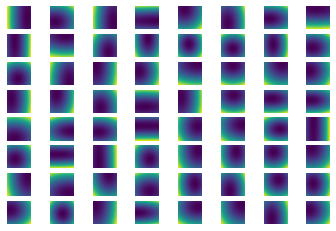

In [18]:

for i in range(int(0.01*np.shape(conv_training_data)[0])):
  ax = plt.subplot(8, 8, i+1)
  ax.axis('off')
  plt.imshow(train_data_2[i])

Data at the end of the list looks like:
Clearly the data has been evenly randomized

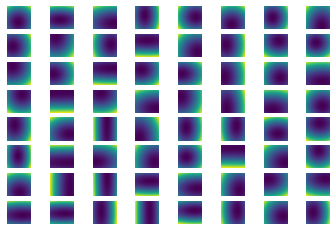

In [20]:
for i in range(int(0.99*np.shape(conv_training_data)[0]),np.shape(conv_training_data)[0]):
  ax = plt.subplot(8, 8, i-int(0.99*np.shape(conv_training_data)[0])+1)
  ax.axis('off')
  plt.imshow(train_data_2[i])

**Defining Function plot_training_history_1 which helps in evaluating our model**

In [21]:
def plot_training_history_1(history, model, eval_images=False):
  figure = plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.tight_layout()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.tight_layout()
  figure.tight_layout()
  plt.show()
  if eval_images:
    loss, accuracy = model.evaluate(conv_test_data, test_labels_2, verbose=False)
  else:
    loss, accuracy = model.evaluate(test_data_2, test_labels_2, verbose=False)
    
  print(f'Test loss: {loss:.3}')
  print(f'Test accuracy: {accuracy:.3}')


  


**Bulinding our CNN model,compiling it and fitting the model with the data**

In [38]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()
model.add(Conv2D(128, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(128,activation='relu'))
model.add(Dense(3, activation='linear'))
opt = Adam(lr=0.0002, beta_1=0.9)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(conv_training_data, train_labels_2, batch_size=32, epochs=20, verbose=True, validation_split=0.2, callbacks=[early_stopper])
model.summary()


Epoch 1/20
160/160 [==============================] - 57s 355ms/step - loss: 0.1256 - accuracy: 0.7014 - val_loss: 0.0240 - val_accuracy: 1.0000
Epoch 2/20
160/160 [==============================] - 59s 371ms/step - loss: 0.0145 - accuracy: 0.8578 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 3/20
160/160 [==============================] - 57s 356ms/step - loss: 0.0111 - accuracy: 0.8932 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 4/20
160/160 [==============================] - 57s 354ms/step - loss: 0.0092 - accuracy: 0.9141 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 5/20
160/160 [==============================] - 57s 354ms/step - loss: 0.0077 - accuracy: 0.9369 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 6/20
160/160 [==============================] - 57s 354ms/step - loss: 0.0064 - accuracy: 0.9496 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 7/20
160/160 [==============================] - 57s 355ms/step - loss: 0.0056 - accuracy: 0.9543 - val_loss: 0.0163 - val_ac

**Plotting using the plot history function to check for the accuracy of our model**

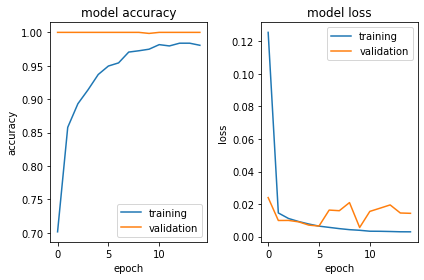

Test loss: 0.00569
Test accuracy: 0.999


In [39]:


plot_training_history_1(history, model, eval_images=True)


**Predicting the Energies for the test data using our Model**

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6115: ComplexWarning: Casting complex values to real discards the imaginary part
  coords = np.column_stack((X, Y)).astype(float, copy=False)


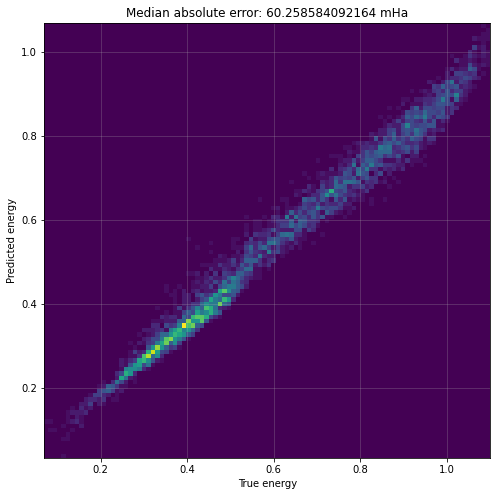

In [40]:
predictions = model.predict(conv_test_data)
prediction_1 = np.array(predictions).flatten()
fig, ax = plt.subplots(1,1, figsize=(8,8))
counts, xedges, yedges = np.histogram2d(test_labels_2.flatten(), prediction_1.flatten(),bins=100)
ax.pcolormesh(xedges, yedges, counts.T)
ax.set_xlabel("True energy")
ax.set_ylabel("Predicted energy")
ax.grid(alpha=0.3)
ax.set_title("Median absolute error: {0} mHa".format(np.median(np.abs(prediction_1.flatten()-test_labels_2.flatten())*1000.)))
fig.show()